<a href="https://colab.research.google.com/github/beidongjiedeguang/my-machine-learning/blob/master/%E5%AF%B9%E6%A8%A1%E5%9E%8B%E8%BF%9B%E8%A1%8C%E8%BF%81%E7%A7%BB%E5%AD%A6%E4%B9%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
# 下载zip文件
import requests
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
r = requests.get(url)
with open ("hymenoptera_data.zip", "wb") as code:
    code.write(r.content)
!unzip hymenoptera_data.zip

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
# 'train'和 'val' 是hymenoptera_data目录下的子目录名
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),# Resize 
        transforms.RandomHorizontalFlip(),# 随机水平翻转
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize(mean,std),这里的mean 和std应该是由图像信息计算得到，而不应是直接写出来
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), #Resize
        transforms.CenterCrop(224),# 以中心为参考点，进行裁剪
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 文件所在祖父目录
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}# 文件所在父目录
# ImageFolder返回：（sample，target）其中target是目标类的class_index。

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes # 返回'train'目录下的子目录名

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
dataset_sizes
class_names 

{'train': 244, 'val': 153}

['ants', 'bees']

In [0]:
next(iter(dataloaders['train']))[0].shape
next(iter(dataloaders['train']))[1].shape
next(iter(dataloaders['val']))[0].shape
next(iter(dataloaders['val']))[1].shape

torch.Size([4, 3, 224, 224])

torch.Size([4])

torch.Size([4, 3, 224, 224])

torch.Size([4])

In [0]:
next(iter(dataloaders['train']))[1]
# 其中，0应该是ants,  1是bees ，因为目录中ants排在前面

tensor([0, 0, 0, 1])

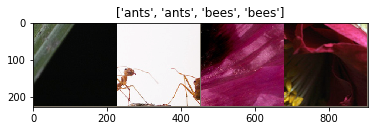

In [0]:
# 查看图片

def imshow(inp, title=None):
    """Imshow for Tensor."""
    # 输入的inp 是一个经过make_grid处理过的三维张量（C,H,W),而matplotlib只认识（H，W,C)格式
    inp = inp.numpy().transpose((1, 2, 0)) # change (c,h,w) to (h,w,c)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean #           这个操作相当于解压，因为之前Normalized操作是将图像范围 (img-mean)/std
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch,这里inputs 是个4维张量，我们要可视化它的话，需要将它第0维度以grid排列，默认一行8个
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 训练模型
现在，让我们编写一个通用函数来训练模型。在这里，我们将说明：

安排学习率
保存最好的模型
在下面，参数scheduler是来自的LR调度程序对象` torch.optim.lr_scheduler`。

In [0]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step() # adjust Learning Rate，调节学习速率
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                # 当phase=='train'时为正，表示对张量应用了requires_grad=True, 其测试集中，不追踪张量梯度，这可以节省很多时间
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    ############################################################
                    print(outputs.shape,labels.shape)
                    print(outputs)
                    print(labels)
                    ############################################################
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
model = models.vgg16(pretrained=True)
print(model)

In [0]:
model = models.vgg19(pretrained=True)
print(model)

In [0]:
model = models.resnet50(pretrained=True)
# print(model)
for para in model.parameters():
    para.requires_grad = False
    
# model.conv1 = torch.nn.Conv2d(1,64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(2048,2)
print(model)

In [0]:
# 由于vgg16最后的全连接层输出为1000，我们需要对其进行修改，而对其它的层保持不变，
# 也就是让其它层不参与梯度更新，只更新最后一层

# 首先让所有参数的requires_grad 至于0
for para in model.parameters():
    para.requires_grad = False
    
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=25088, out_features=4096, bias=True),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(in_features=4096, out_features=4096, bias=True),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(in_features=4096, out_features=2, bias=True) # 只改变了这一全连接层，同时，它的requires_grad 会被置于 True
  )
print(model)

In [0]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.classifier.parameters(),lr = 1e-6)# 内部的参数替换为.classifier.parameters()
# optimizer = optim.Adam(model.fc.parameters(),lr = 1e-6)# 内部的参数替换为.classifier.parameters()
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=1)# 调节学习速率，经过每个step变为之前的gamma倍

# lr_scheduler.StepLR 参考文档：
# https://pytorch.org/docs/stable/optim.html?highlight=lr_scheduler#torch.optim.lr_scheduler.StepLR


In [0]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
torch.Size([4, 2]) torch.Size([4])
tensor([[-0.0810,  0.6625],
        [-0.4868,  0.3630],
        [-0.7228,  1.3376],
        [ 0.9664, -1.0160]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([1, 1, 1, 0], device='cuda:0')
torch.Size([4, 2]) torch.Size([4])
tensor([[ 0.4993, -0.9809],
        [-0.5593,  0.6837],
        [ 0.2663, -0.0457],
        [-0.3143,  0.6873]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0, 1, 0, 1], device='cuda:0')
torch.Size([4, 2]) torch.Size([4])
tensor([[ 1.4663, -1.1864],
        [ 0.5189, -0.8902],
        [-0.1263,  0.2863],
        [ 0.1506,  0.0351]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0, 0, 1, 1], device='cuda:0')
torch.Size([4, 2]) torch.Size([4])
tensor([[ 0.1133, -0.1467],
        [ 0.2012, -0.1329],
        [ 0.4293, -0.0611],
        [-0.3951,  0.9412]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0, 0, 0, 1], device='cuda:0')
torch.Size([4, 2]) torch.Size([4])
tensor([[-0.2456,  0.5311],
    

KeyboardInterrupt: ignored